In [24]:
import collections
import numpy as np
import pandas as pd
import csv
from sklearn.metrics import confusion_matrix
#directory of the training and validation files
file_name_training="/home/merna/binaryClassification/binary_classifier_data/training.csv"
file_name_test="/home/merna/binaryClassification/binary_classifier_data/validation.csv"
list_of_words = []
lst = []
non_categorical =['variable2','variable3','variable8']
all_numeric_data = ['variable2','variable3','variable8','variable14','variable15','variable17','variable19']
categorical =['variable1','variable4','variable5','variable6','variable7','variable9','variable10','variable12','variable13']
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})
import warnings
warnings.filterwarnings('ignore')


Readin dataframes of training data and test data 

In [25]:
read1 = pd.read_csv(file_name_training,delimiter=';')
read2 = pd.read_csv(file_name_test,delimiter=';')

In [30]:
#for handling missing values
def fillNA_in_categorical(read):
     for x in categorical:
    # make dummy variables, count and sort descending:
       most_common = pd.get_dummies(read[x]).sum().sort_values(ascending=False).index[0]  
       read[x].fillna(most_common,inplace=True)
     return read
#for handling wrong float numbers and replace , with .
def fix_float(read):
    
       read= list(read)
       read = [float(str(indx).replace(',', '.')) for indx in read]     
       return read
#to make no --> 0 & yes -->1
def replace_labels_with_binaryValues(labels):
    for i in range(0,len(labels)):
        if labels[i]=='no.':
            labels[i]=0
        else:
            labels[i]=1
    return labels



    

call all functions to clean data 

and i change categorical features to numerical representation using pandas one hot encoding
and after recieve fix_float we replace nan value with median

In [31]:
#I DROpped variable 18 as more than 70% are NAN values so it wont affect my model 
train_labels = list(read1['classLabel'])
train_features = read1.drop(['classLabel','variable18'], axis=1)
test_labels = list(read2['classLabel'])
test_features = read2.drop(['classLabel','variable18'], axis=1)

def cleaning():
     global train_labels
     global test_labels
     global train_features
     global test_features
     #handle missing values in training data
     fillNA_in_categorical(train_features)
     #handle missing values in test data
     fillNA_in_categorical(test_features)
     #handle labels of train
     train_labels = replace_labels_with_binaryValues(train_labels)
     # handle label of test
     test_labels= replace_labels_with_binaryValues(test_labels) 
     #get numeric representation of train and test data using one hot encoding
     train_features['train']=1
     test_features['train']=0
     #this part to handle that train and test must have same size of features
     combined =pd.concat([train_features, test_features])
     combined = pd.get_dummies(combined, columns=categorical)
     train_features = combined[combined['train']==1]
     test_features= combined[combined['train']==0]
     train_features.drop(['train'],axis=1,inplace=True)
     test_features.drop(['train'],axis=1,inplace=True)
     #handle float number for train and test data
     for x in non_categorical:
       train_features[x]=fix_float(train_features[x])
       test_features[x]=fix_float(test_features[x])
     #handle missing values in numerical features
     for x in all_numeric_data:
         median = train_features[x].median()
         train_features[x].fillna(median, inplace=True)
         median = test_features[x].median()
         test_features[x].fillna(median, inplace=True)
     

     

In [32]:

cleaning()
from sklearn.preprocessing import MinMaxScaler
#scale the data in range 0--->1
scaler = MinMaxScaler()
scaler.fit(train_features)

scaler.transform(train_features)
scaler.transform(test_features)

array([[0.2794, 0.2679, 0.0556, ..., 0.0000, 0.0000, 1.0000],
       [0.1478, 0.0639, 0.0189, ..., 1.0000, 0.0000, 0.0000],
       [0.3409, 0.0268, 0.0205, ..., 1.0000, 0.0000, 0.0000],
       ...,
       [0.2568, 0.0000, 0.0439, ..., 1.0000, 0.0000, 0.0000],
       [0.0890, 0.0134, 0.0702, ..., 1.0000, 0.0000, 0.0000],
       [0.2469, 0.2321, 0.1096, ..., 1.0000, 0.0000, 0.0000]])

In [33]:
sum = 0
for i in range(0,len(train_labels)):
    sum+= train_labels[i]
print(sum," total ",len(train_labels))

#this to check if the data balanced or not to know which mitric we will use so it 
#appears that it is not balanced so i will use F1 Score

3424  total  3700


Building the model
Trying naive bayes and calculating F1 Score

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
clf = GaussianNB()
clf.fit(train_features, train_labels)
pred = clf.predict(test_features)
print("F1 for naive bayes ",f1_score(test_labels, pred, average='macro')*100)
print(confusion_matrix(test_labels, pred))


F1 for naive bayes  68.9875950380152
[[71 36]
 [26 67]]


KNN classifier and i used k fold cross validation to tune knn parameters

1


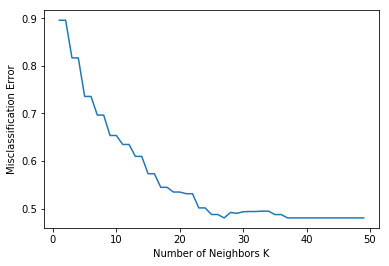

F1 KNN of testDAta 59.74235104669887
[[68 39]
 [41 52]]


In [35]:
def KNN():    
    neighbors = list(range(1,50))
    cv_scores = []
    #tune k paramter 
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        # apply k fold cross validation to tune knn and calculate score using f1score
        scores = cross_val_score(knn, train_features, train_labels, cv=10, scoring='f1_macro')
        cv_scores.append(scores.mean())
#MISCLASSIFICATION SQUARE ERROR
    MSE = [1 - x for x in cv_scores]
    #optimal k that has min mse
    optimal_k = neighbors[MSE.index(min(MSE))]
    print(optimal_k)
    plt.plot(neighbors, cv_scores)
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()
    clf = KNeighborsClassifier(n_neighbors = optimal_k)
    clf.fit(train_features, train_labels)
    output_labels_KNN = clf.predict(test_features)
    print("F1 KNN of testDAta",f1_score(test_labels, output_labels_KNN, average='macro')*100)
    print(confusion_matrix(test_labels, output_labels_KNN))
KNN()

Random forest

In [36]:
clfRandomForest = RandomForestClassifier(n_estimators=300,min_samples_split = 2, min_samples_leaf = 2,max_features = 'sqrt',         
    max_depth = 2000)
clfRandomForest.fit(train_features, train_labels)  
output_labels_randomForest = clf.predict(test_features)
print("F1 of randomforest  :",f1_score(test_labels, output_labels_randomForest, average='macro')*100)
print(confusion_matrix(test_labels, output_labels_randomForest))

F1 of randomforest  : 68.9875950380152
[[71 36]
 [26 67]]


LDA 

In [37]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()

clf.fit(train_features, train_labels)
output_labels_LDA = clf.predict(test_features)
print("F1 of LDA  :",f1_score(test_labels, output_labels_LDA, average='macro')*100)
print(confusion_matrix(test_labels, output_labels_LDA))

F1 of LDA  : 82.93857888398233
[[77 30]
 [ 4 89]]
